# Network embedding

In this notebook we aim to derive a node embedding for the regulatory network of U2OS cells that we derived in our preceeding analyses. To this end, we will train a Graph-convolutional AutoEncoder. To assess the stability of the embeddings we will experiment with different input features, training objectives and initializations and compare the clustering of the inferred latent spaces i.a. to embeddings obtained from a DeepWalk model. On the basis of those analyses we will finally identify a stable node embedding for the genes in the input regulatory network. Those embeddings will span our estimate of the regulatory state in U2OS cells.

---

## 0. Environmental setup

First, we will load all required libraries.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import sys
import os
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import community as community_louvain
from torch_geometric.data import Data
from torch import LongTensor, FloatTensor
from node2vec import Node2Vec
from torch_geometric.nn import GAE
from torch_geometric.utils import (
    train_test_split_edges,
    from_networkx,
    negative_sampling,
    to_dense_adj,
)
import torch_geometric.transforms as T
from torch_geometric.nn import InnerProductDecoder
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import scanpy as sc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import adjusted_mutual_info_score
from scipy.stats import spearmanr, pearsonr
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import pdist, squareform
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

sys.path.append("../../../")

from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *
from src.utils.basic.io import get_genesets_from_gmt_file
from src.models.ae import CustomGAE, GCNEncoder

seed = 1234

plt.style.use("default")

%load_ext nb_black

<IPython.core.display.Javascript object>

In [104]:
def add_pos_negative_edge_indices(graph_data, add_pos_edges=True):
    selected_nodes = torch.LongTensor(list(range(graph_data.num_nodes)))[
        graph_data.node_mask
    ]
    adj = torch.zeros(graph_data.num_nodes, graph_data.num_nodes, dtype=torch.bool)
    adj[graph_data.edge_index[0], graph_data.edge_index[1]] = True
    adj = adj[selected_nodes]
    adj = adj[:, selected_nodes]
    pos_edge_index = adj.nonzero(as_tuple=False).t()
    neg_adj = torch.ones(len(adj), len(adj), dtype=torch.bool)
    neg_adj[pos_edge_index[0], pos_edge_index[1]] = False
    neg_edge_index = neg_adj.nonzero(as_tuple=False).t()
    #     all_pos_edge_index = []
    #     for idx in graph_data.edge_index.t():
    #         all_pos_edge_index.append((idx[0].item(), idx[1].item()))
    #     for i in range(graph_data.num_nodes):
    #         for j in range(graph_data.num_nodes):
    #             if graph_data.node_mask[i] == 1 == graph_data.node_mask[j] and i != j:
    #                 if (i, j) in all_pos_edge_index:
    #                     pos_edge_index.append((i, j))
    #                 else:
    #                     neg_edge_index.append((i, j))
    if add_pos_edges:
        graph_data.pos_edge_index = torch.LongTensor(pos_edge_index)
    graph_data.neg_edge_index = torch.LongTensor(neg_edge_index)
    return graph_data

<IPython.core.display.Javascript object>

In [3]:
def network_train_val_test_split(network, train_val_test_size, random_state=1234):
    train_size, val_size, test_size = train_val_test_size
    nodes = list(network.nodes())
    train_val_nodes, test_nodes = train_test_split(
        nodes, test_size=test_size, random_state=random_state
    )
    train_nodes, val_nodes = train_test_split(
        train_val_nodes, test_size=val_size / (1 - test_size), random_state=random_state
    )

    train_network = nx.Graph(network.subgraph(train_nodes))
    for edge in train_network.edges(data=True):
        edge[-1]["edge_mask"] = True
    for node in train_network.nodes(data=True):
        node[-1]["node_mask"] = True
    train_network.name = "train_network"

    val_network = nx.Graph(network.subgraph(train_nodes + val_nodes))
    for edge in val_network.edges(data=True):
        edge[-1]["edge_mask"] = edge[0] in val_nodes and edge[1] in val_nodes
    for node in val_network.nodes(data=True):
        node[-1]["node_mask"] = node[0] in val_nodes
    val_network.name = "val_network"

    test_network = nx.Graph(network.subgraph(train_nodes + val_nodes + test_nodes))
    for edge in test_network.edges(data=True):
        edge[-1]["edge_mask"] = edge[0] in test_nodes and edge[1] in test_nodes
    for node in test_network.nodes(data=True):
        node[-1]["node_mask"] = node[0] in test_nodes
    test_network.name = "test_network"

    return train_network, val_network, test_network

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we will read in the regulatory graph data along side with a scRNA-seq data set and a number of hallmark geneset information. The latter two will be used to define further node features and update the correlation information for the interactions in the graph.

In [4]:
spearman_interactome = nx.read_gpickle(
    "../../../data/ppi/inference_results/cv/conf_hub_spearman_sol_cv.pkl"
)
print(nx.info(spearman_interactome))

Name: conf_hub_spearman_sol
Type: Graph
Number of nodes: 244
Number of edges: 521
Average degree:   4.2705


<IPython.core.display.Javascript object>

In [5]:
gex_adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
gex_adata.var_names_make_unique()
gex_data = pd.DataFrame(
    gex_adata.X, columns=gex_adata.var_names, index=gex_adata.obs_names
)
gex_data.columns = [c.upper() for c in gex_data.columns]
gex_data = gex_data.loc[
    :, set(spearman_interactome.nodes()).intersection(gex_data.columns)
]

<IPython.core.display.Javascript object>

In addition to the 50 Hallmark gene sets, we also load the gene sets corresponding to pathways involved in mechanotransduction: cell cycle control, regulation of chromatin organization and actin cytoskeleton, DNA damage repair, cell death and transcription factors.

In [6]:
cc_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_cycle.txt", index_col=0).index
)
co_genes = set(
    pd.read_csv("../../../data/other/reactome_chrom_org.txt", index_col=0).index
)
dr_genes = set(
    pd.read_csv("../../../data/other/reactome_dna_repair.txt", index_col=0).index
)
cd_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_death.txt", index_col=0).index
)
cr_genes = set(
    pd.read_csv("../../../data/other/kegg_reg_act_cytoskeleton.txt", index_col=0).index
)
tfs = set(pd.read_csv("../../../data/other/human_tf_list.txt", index_col=0).index)

spec_results = pd.read_csv(
    "../../../data/other/specificity_screen_results_cv.csv", index_col=0
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)
hallmark_geneset_dict = get_genesets_from_gmt_file(
    "../../../data/other/h.all.v7.4.symbols.gmt"
)

<IPython.core.display.Javascript object>

---
---

## 2. Preprocessing

We will now set the respective node and edge attributes computed based on the previously loaded information. Note, that the single-cell gene expression data is min-max-scaled.

### 2.1. Attribute setting

In [7]:
gex_data_z = pd.DataFrame(
    MinMaxScaler().fit_transform(gex_data.transpose()),
    index=gex_data.transpose().index,
    columns=gex_data.transpose().columns,
).transpose()

<IPython.core.display.Javascript object>

In [8]:
for node in spearman_interactome.nodes(data=True):
    node[-1]["sc_gex"] = np.array(gex_data_z.loc[:, node[0]])
    node[-1]["sc_gex"] = node[-1]["sc_gex"]
    node[-1]["name"] = node[0]
    node[-1]["cell_cycle"] = node[0] in cc_genes
    node[-1]["chromatin_org"] = node[0] in co_genes
    node[-1]["dna_repair"] = node[0] in dr_genes
    node[-1]["cytoskeleton_org"] = node[0] in cr_genes
    node[-1]["cell_death"] = node[0] in cd_genes
    node[-1]["tf"] = node[0] in tfs
    node[-1]["spec_target"] = node[0] in spec_orf_targets

    gene_memberships = []
    for geneset in hallmark_geneset_dict.values():
        if node[0] in geneset:
            gene_memberships.append(1.0)
        else:
            gene_memberships.append(0.0)

    node[-1]["hallmark"] = np.array(gene_memberships)
    node[-1]["sc_gex_hallmark"] = np.concatenate(
        [node[-1]["sc_gex"], node[-1]["hallmark"]]
    )

for edge in spearman_interactome.edges(data=True):
    edge[-1]["spearmanr"] = spearmanr(
        gex_data.loc[:, edge[0]], gex_data.loc[:, edge[1]]
    )[0]
    edge[-1]["pearsonr"] = pearsonr(gex_data.loc[:, edge[0]], gex_data.loc[:, edge[1]])[
        0
    ]

<IPython.core.display.Javascript object>

---


### 2.2. Data splitting

Next, we want split the node set in a training, validation and test set. Using these node sets, we will want to assess the generalizability of the graph autoencoder to unseen nodes. Thus, we propose the following experimental setup:
1. Split the node sets randomly into a training, validation and test set.
2. Define the training network as the subnetwork induced by the training node set, the validation network as induced by the training and validation node set and the test network as the complete network.
3. For each set: Construct an corresponding edge mask that is one only for edge where both nodes connected by the edge are in the corresponding node set
    
4. Train the GAE using the corresponding input graphs for message passing and the masks to compute the loss.

#### Effect of the data splitting

However, it is important to mention that by that procedure the training and validation network will feature a number of singeltons (disconnected nodes) due to the splitting. This is because there are multiple nodes with a degree of 1 in the network as shown below.

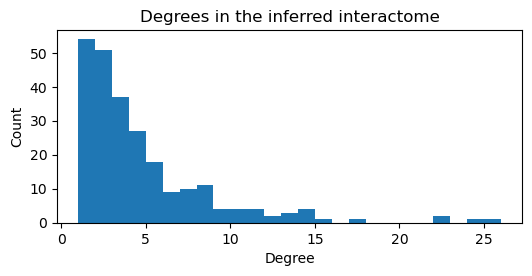

<IPython.core.display.Javascript object>

In [9]:
interactome_degrees = []
for node in spearman_interactome.nodes():
    interactome_degrees.append(spearman_interactome.degree(node))
plt.figure(figsize=[6, 2.5])
plt.hist(interactome_degrees, bins=25)
plt.title("Degrees in the inferred interactome")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

In fact we see that 54 nodes in the network are only connected by a single edge. As a consequence selecting any of those for the validation or test set create disconnected nodes in the training network.

To show that we perform three different random splits and visualize the degree distributions in both the training and test network. We decide to keep 20% of the nodes for testing and thus infer the corresponding subgraphs after sampling those.

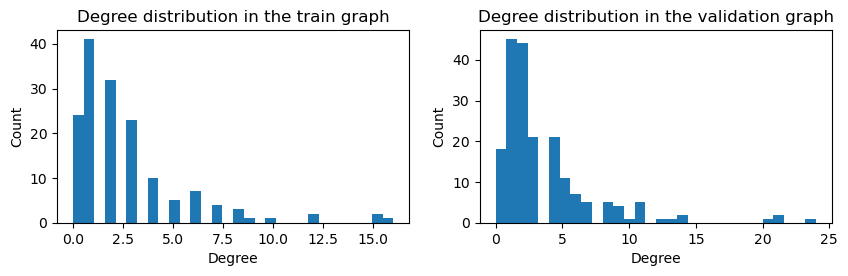

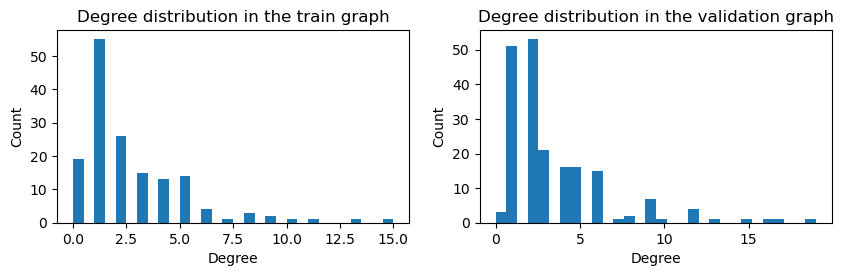

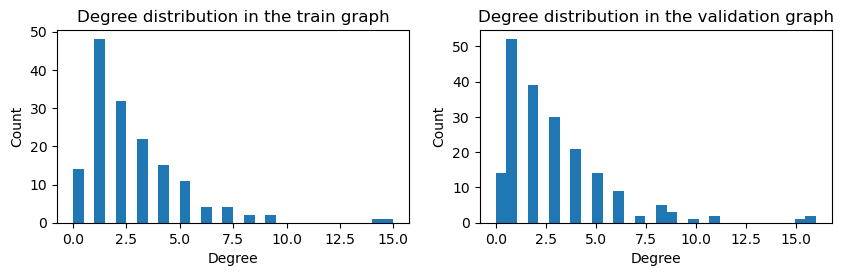

<IPython.core.display.Javascript object>

In [10]:
nodes = list(range(len(spearman_interactome)))

for i in range(3):
    train_val_nodes, test_nodes = train_test_split(nodes, test_size=0.2)
    train_nodes, val_nodes = train_test_split(train_val_nodes, test_size=0.2)
    train_interactome = spearman_interactome.subgraph(
        np.array(spearman_interactome.nodes())[train_nodes]
    )
    val_interactome = spearman_interactome.subgraph(
        np.array(spearman_interactome.nodes())[val_nodes + train_nodes]
    )
    train_degrees = []
    val_degrees = []
    for node in train_interactome.nodes():
        train_degrees.append(train_interactome.degree(node))
    for node in val_interactome.nodes():
        val_degrees.append(val_interactome.degree(node))
    fig, ax = plt.subplots(figsize=[10, 2.5], ncols=2)
    ax[0].hist(train_degrees, bins=30)
    ax[0].set_title("Degree distribution in the train graph")
    ax[0].set_ylabel("Count")
    ax[0].set_xlabel("Degree")

    ax[1].hist(val_degrees, bins=30)
    ax[1].set_title("Degree distribution in the validation graph")
    ax[1].set_ylabel("Count")
    ax[1].set_xlabel("Degree")
    plt.show()

We see that we have around 10-20 singeltons in each in random training graph and around 5-15 in the validation set. Note that for those the only supervisory signal will be the feature reconstruction loss backpropagated through the network.

---

#### Data splitting

Nonetheless we will proceed now to split the data. To this end the node set of the network will be split in 0.8 training, 0.1 validation and 0.1 testing.

In [105]:
train_network, val_network, test_network = network_train_val_test_split(
    spearman_interactome, train_val_test_size=[0.8, 0.1, 0.1]
)
print(nx.info(train_network))
print(nx.info(val_network))
print(nx.info(test_network))

Name: train_network
Type: Graph
Number of nodes: 194
Number of edges: 338
Average degree:   3.4845
Name: val_network
Type: Graph
Number of nodes: 219
Number of edges: 429
Average degree:   3.9178
Name: test_network
Type: Graph
Number of nodes: 244
Number of edges: 521
Average degree:   4.2705


<IPython.core.display.Javascript object>

---

### 2.2 Data preparation

Next, we will construct corresponding graph data objects compatible with the pytorch_geometric package from the corresponding subnetworks.

In [106]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

train_data = from_networkx(train_network)
train_data = add_pos_negative_edge_indices(train_data, add_pos_edges=False)
train_data.id = torch.FloatTensor(np.identity(train_data.num_nodes))
train_data = T.ToDevice(
    device,
    attrs=[
        "id",
        "sc_gex",
        "pbulk_gex",
        "hallmark",
        "sc_gex_hallmark",
        "pbulk_gex_hallmark",
    ],
)(train_data)

<IPython.core.display.Javascript object>

In [107]:
val_data = from_networkx(val_network)
val_data = add_pos_negative_edge_indices(val_data)
val_data.id = torch.FloatTensor(np.identity(val_data.num_nodes))
val_data = T.ToDevice(
    device,
    attrs=[
        "id",
        "sc_gex",
        "pbulk_gex",
        "hallmark",
        "sc_gex_hallmark",
        "pbulk_gex_hallmark",
    ],
)(val_data)

<IPython.core.display.Javascript object>

In [108]:
test_data = from_networkx(test_network)
test_data = add_pos_negative_edge_indices(test_data)
test_data.id = torch.FloatTensor(np.identity(test_data.num_nodes))
test_data = T.ToDevice(
    device,
    attrs=[
        "id",
        "sc_gex",
        "pbulk_gex",
        "hallmark",
        "sc_gex_hallmark",
        "pbulk_gex_hallmark",
    ],
)(test_data)

<IPython.core.display.Javascript object>

In [109]:
data_dict = {
    "train": train_data,
    "val": val_data,
    "test": test_data,
}
data_dict

{'train': Data(edge_index=[2, 676], prize=[194], sc_gex=[194, 1126], name=[194], cell_cycle=[194], chromatin_org=[194], dna_repair=[194], cytoskeleton_org=[194], cell_death=[194], tf=[194], spec_target=[194], hallmark=[194, 50], sc_gex_hallmark=[194, 1176], node_mask=[194], mi_score=[676], pearsonr=[676], spearmanr=[676], mi=[676], cost=[676], edge_mask=[676], num_nodes=194, neg_edge_index=[2, 36960], id=[194, 194]),
 'val': Data(edge_index=[2, 858], prize=[219], sc_gex=[219, 1126], name=[219], cell_cycle=[219], chromatin_org=[219], dna_repair=[219], cytoskeleton_org=[219], cell_death=[219], tf=[219], spec_target=[219], hallmark=[219, 50], sc_gex_hallmark=[219, 1176], node_mask=[219], mi_score=[858], pearsonr=[858], spearmanr=[858], mi=[858], cost=[858], edge_mask=[858], num_nodes=219, pos_edge_index=[2, 10], neg_edge_index=[2, 615], id=[219, 219]),
 'test': Data(edge_index=[2, 1042], prize=[244], sc_gex=[244, 1126], name=[244], cell_cycle=[244], chromatin_org=[244], dna_repair=[244], 

<IPython.core.display.Javascript object>

---

## 3. Model setup


After preparing the data we will define the graph and feature autoencoder model. We decide to use the hallmark gene set membership and the single-cell gene expression data as input features.

In [154]:
feat_decoder = FeatureDecoder(
    latent_dim=16, hidden_dims=[256, 512, 1024], output_dim=50
)
gae = CustomGAE(
    encoder=GCNEncoder(
        in_channels=50,
        hidden_dim=32,
        out_channels=16,
    ),
    adj_decoder=InnerProductDecoder(),
    feat_decoder=feat_decoder,
    alpha=1,
    beta=0,
    feat_loss=torch.nn.MSELoss(),
)
print(gae)

CustomGAE(
  (gae): GAE(
    (encoder): GCNEncoder(
      (model): Sequential(
        (0): GCNConv(50, 32)
        (1): ReLU()
        (2): GCNConv(32, 16)
      )
    )
    (decoder): InnerProductDecoder()
  )
  (feat_decoder): FeatureDecoder(
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=16, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (2): Sequential(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (3): Linear(in_features=1024, out_feat

<IPython.core.display.Javascript object>

In [159]:
optimizer = torch.optim.Adam(gae.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

In [157]:
def process_single_epoch_gae(
    model,
    data,
    node_feature_key,
    mode,
    optimizer,
    edge_weight_key=None,
    reconstruct_features: bool = False,
):
    inputs = getattr(data, node_feature_key).float()
    if edge_weight_key is not None:
        edge_weight = getattr(data, edge_weight_key).float()
    else:
        edge_weight = None

    if mode == "train":
        model.train()
        optimizer.zero_grad()
        latents = model.encode(
            inputs,
            data.edge_index,
            edge_weight=edge_weight,
        )
        # Negative edges created via negative sampling
        if reconstruct_features:
            loss = model.recon_loss(inputs, latents, data.edge_index)
        else:
            loss = model.recon_loss(latents, data.edge_index)
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            latents = model.encode(inputs, data.edge_index, edge_weight=edge_weight)
            if reconstruct_features:
                loss = model.recon_loss(
                    inputs[data.node_mask],
                    latents[data.node_mask],
                    data.pos_edge_index,
                    data.neg_edge_index,
                )
            else:
                loss = model.recon_loss(
                    latents[data.node_mask], data.pos_edge_index, data.neg_edge_index
                )

    return loss.item()

<IPython.core.display.Javascript object>

100%|██████████| 1000/1000 [00:16<00:00, 59.83it/s]


<AxesSubplot:xlabel='epoch', ylabel='loss'>

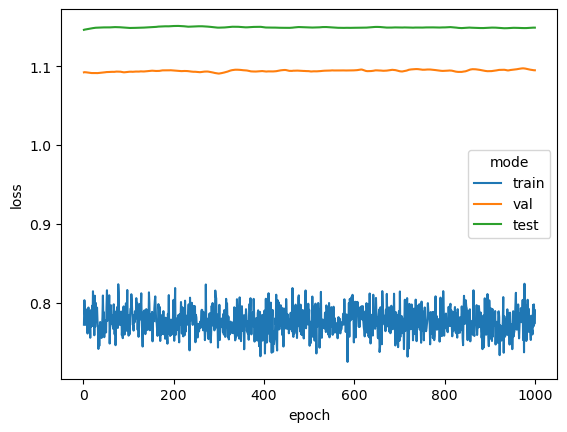

<IPython.core.display.Javascript object>

In [160]:
loss_hist = {"epoch": [], "loss": [], "mode": []}
for i in tqdm(range(1000)):
    for mode in ["train", "val", "test"]:
        loss = process_single_epoch_gae(
            gae,
            data_dict[mode],
            node_feature_key="hallmark",
            mode=mode,
            optimizer=optimizer,
            reconstruct_features=True,
        )
        loss_hist["epoch"].append(i + 1)
        loss_hist["loss"].append(loss)
        loss_hist["mode"].append(mode)

loss_hist = pd.DataFrame(loss_hist)
sns.lineplot(data=loss_hist, x="epoch", y="loss", hue="mode")